# geocoding à partir d'une liste récupérée sur internet
### http://www.horaires.tv/gares/liste_gare_corse.html

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(8,8)

import requests
import json

import pandas as pd
import numpy as np

import geopandas as gpd

from tqdm import tqdm
from shapely import geometry

# Chargement des données 

In [2]:
training_folder = r'../'
gis_folder = training_folder + r'gis/corse/'
data_folder = training_folder + r'data/corse/'

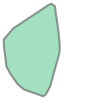

In [3]:
# création de la géométrie : corse
communes = gpd.read_file(gis_folder + r'communes_corse.shp')
convex_corse = communes.dissolve([0] * len(communes)).convex_hull[0]
convex_corse

In [4]:
# lecture de la table des gares
gares = pd.read_csv(data_folder + 'gares_corse.txt', encoding='latin', header=None)
gares.columns = ['name']

In [5]:
gares.head(2)

,name
0,Gare de Campo dell'Oro (Ajaccio)
1,Gare de Salines (Ajaccio)


In [6]:
gares['name'] += ', corse'

In [7]:
gares.head(2)

,name
0,"Gare de Campo dell'Oro (Ajaccio), corse"
1,"Gare de Salines (Ajaccio), corse"


# création de la requête 

In [8]:
url_root = 'https://api-adresse.data.gouv.fr/search/?q='

def geocoding_response(address):
    return requests.get(url_root + address + '&limit=1')   

In [9]:
tqdm.pandas() # pour permettre d'utiliser progress_apply à la place de apply
gares['responses'] = gares['name'].progress_apply(geocoding_response)

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 61/61 [00:03<00:00, 15.74it/s]


In [10]:
def response_to_geometry(response):
    try:
        location = json.loads(response.text)['features'][0]['geometry']['coordinates']
        # print(location)
        return geometry.Point(location[0], location[1])
     
    except IndexError:
        return np.nan

In [11]:
gares['geometry'] = gares['responses'].apply(response_to_geometry)

In [12]:
gares['stop'] = gares.index

In [13]:
gares = gpd.geodataframe.GeoDataFrame(gares[['name','stop', 'geometry']].dropna())

In [14]:
gares.intersects(convex_corse).mean() # pourcentage des gares qui sont géocodées en corse

0.847457627118644

In [15]:
gares = gares.loc[gares.intersects(convex_corse)] # on ne garde que les gares qui sont codées en corse

In [16]:
gares.to_file(gis_folder + 'stops_corse.shp')

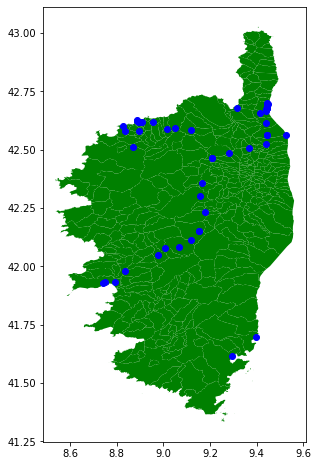

In [17]:
communes_plot = communes.plot(color='green')
gares.plot(ax=communes_plot, color='blue')
plt.savefig(r'../plot/geocoding.png', bbox_inches='tight')

In [18]:
response = geocoding_response("""Gare de Campo dell'Oro (Ajaccio), corse""")

In [19]:
text = response.text

In [20]:
with open(data_folder + 'geocoding_response.txt', 'w') as file:
    file.write(text)